<a href="https://colab.research.google.com/github/dupsys/SlangDict/blob/master/AugMix_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.0

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.0`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
import os
import numpy as np
import pandas as pd
import dask as dd
import matplotlib.pyplot as plt

from PIL import Image
from PIL import ImageOps

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.callbacks import Callback, ModelCheckpoint
from tensorflow.keras.regularizers import l2

In [0]:
img_dim = (32, 32, 3)
IMAGE_SIZE = img_dim[0]
num_classes = 10

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train = x_train.astype(np.float32) / 255.
x_test = x_test.astype(np.float32) / 255.

y_train_cat = to_categorical(y_train, num_classes=num_classes).astype(np.float32)
y_test_cat = to_categorical(y_test, num_classes=num_classes).astype(np.float32)

In [0]:
def int_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval .
    Args:
        level: Level of the operation that will be in [0, `PARAMETER_MAX`].
        maxval: Maximum value that the operation can have. This will be 
                scaled to level/PARAMETER_MAX.
    Returns:
        An int that results from scaling `maxval` according to `level`.
    """
    return int(level * maxval / 10)


def float_parameter(level, maxval):
    """Helper function to scale `val` between 0 and maxval.
    Args:
        level: Level of the operation that will be in [0, `PARAMETER_MAX`].
        maxval: Maximum value that the operation can have. This will be 
                scaled to level/PARAMETER_MAX.
    Returns:
        A float that results from scaling `maxval` according to `level`.
    """
    return float(level) * maxval / 10.


def sample_level(n):
    return np.random.uniform(low=0.1, high=n)


def autocontrast(pil_img, _):
    return ImageOps.autocontrast(pil_img)


def equalize(pil_img, _):
    return ImageOps.equalize(pil_img)


def posterize(pil_img, level):
    level = int_parameter(sample_level(level), 4)
    return ImageOps.posterize(pil_img, 4 - level)


def rotate(pil_img, level):
    degrees = int_parameter(sample_level(level), 30)
    if np.random.uniform() > 0.5:
        degrees = -degrees
    return pil_img.rotate(degrees, resample=Image.BILINEAR)


def solarize(pil_img, level):
    level = int_parameter(sample_level(level), 256)
    return ImageOps.solarize(pil_img, 256 - level)


def shear_x(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                            Image.AFFINE, (1, level, 0, 0, 1, 0),
                            resample=Image.BILINEAR)


def shear_y(pil_img, level):
    level = float_parameter(sample_level(level), 0.3)
    if np.random.uniform() > 0.5:
        level = -level
    return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                            Image.AFFINE, (1, 0, 0, level, 1, 0),
                            resample=Image.BILINEAR)


def translate_x(pil_img, level):
    level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                            Image.AFFINE, (1, 0, level, 0, 1, 0),
                            resample=Image.BILINEAR)


def translate_y(pil_img, level):
    level = int_parameter(sample_level(level), IMAGE_SIZE / 3)
    if np.random.random() > 0.5:
        level = -level
    return pil_img.transform((IMAGE_SIZE, IMAGE_SIZE),
                            Image.AFFINE, (1, 0, 0, 0, 1, level),
                            resample=Image.BILINEAR)


def apply_op(image, op, severity):
    image = np.clip(image * 255., 0, 255).astype(np.uint8)
    pil_img = Image.fromarray(image)  # Convert to PIL.Image
    pil_img = op(pil_img, severity)
    return np.asarray(pil_img, dtype=np.float32) / 255.

In [0]:
augmentations = [autocontrast, 
                    equalize, 
                    posterize, 
                    rotate, 
                    solarize, 
                    shear_x, 
                    shear_y,
                    translate_x, 
                    translate_y]

In [0]:
def augment_and_mix(image, severity=3, width=3, depth=-1, alpha=1.):
    """Perform AugMix augmentations and compute mixture.
    Args:
        image: Raw input image as ndarray shape (h, w, c)
        severity: Severity of underlying augmentation operators (1-10).
        width: Width of augmentation chain
        depth: Depth of augmentation chain. -1 or (1, 3)
        alpha: Probability coefficient for Beta and Dirichlet distributions.
    Returns:
        mixed: Augmented and mixed image.
    """
    ws = np.random.dirichlet([alpha] * width).astype(np.float32)
    m  = np.random.beta(alpha, alpha)
    mix = np.zeros_like(image).astype(np.float32)

    for i in range(width):
        image_aug = image.copy()
        depth = depth if depth > 0 else np.random.randint(1, 4)
        for _ in range(depth):
            op = np.random.choice(augmentations)
            image_aug = apply_op(image_aug, op, severity)
            # Preprocessing commutes since all coefficients are convex
            mix += ws[i] * image_aug

    # mix the image and return 
    mixed = (1 - m)*image + m*mix
    return mixed

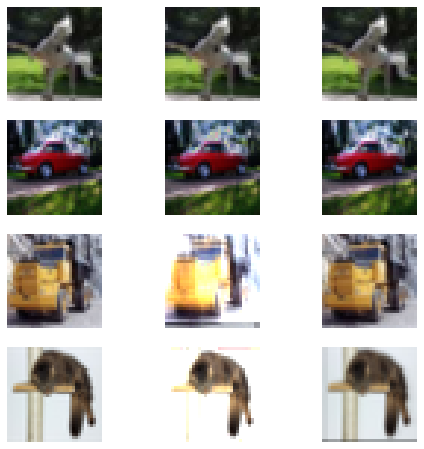

In [0]:
f, ax = plt.subplots(4, 3, figsize=(8,8))
for i in range(4):
    idx = np.random.randint(1000)
    orig = x_train[idx]
    aug1 = augment_and_mix(orig)
    aug2 = augment_and_mix(orig)
    orig = np.clip(orig*255., 0, 255.).astype(np.uint8)
    aug1 = np.clip(aug1*255., 0, 255.).astype(np.uint8)
    aug2 = np.clip(aug2*255., 0, 255.).astype(np.uint8)
    ax[i, 0].imshow(orig)
    ax[i, 1].imshow(aug1)
    ax[i, 2].imshow(aug2)
    ax[i, 0].axis('off')
    ax[i, 1].axis('off')
    ax[i, 2].axis('off')
plt.show()

## Resnet20 model

In [0]:
version = 1
n = 3
depth = n * 6 + 2

###########################################################################

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = layers.Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
    else:
        if batch_normalization:
            x = layers.BatchNormalization()(x)
        if activation is not None:
            x = layers.Activation(activation)(x)
        x = conv(x)
    return x

##########################################################################

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = layers.Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = layers.add([x, y])
            x = layers.Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = layers.AveragePooling2D(pool_size=8)(x)
    y = layers.Flatten()(x)
    x = layers.Dropout(0.5)(y)
    outputs = layers.Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs, name="resnet"+str(depth))
    return model

In [0]:
input_shape = x_train.shape[1:]
model = resnet_v1(input_shape, depth)
model.summary()

Model: "resnet20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_21 (Conv2D)              (None, 32, 32, 16)   448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 32, 32, 16)   64          conv2d_21[0][0]                  
__________________________________________________________________________________________________
activation_19 (Activation)      (None, 32, 32, 16)   0           batch_normalization_19[0][0]     
___________________________________________________________________________________________

In [0]:
# loss function to be used for training
kld = tf.keras.losses.KLDivergence()
entropy = tf.keras.losses.CategoricalCrossentropy()

def jsd_loss_fn(y_true, y_pred_clean, y_pred_aug1, y_pred_aug2):
    # cross entropy loss that is used for clean images only
    loss = entropy(y_true, y_pred_clean)

    mixture = (y_pred_clean + y_pred_aug1 + y_pred_aug2) / 3.
    mixture = tf.math.log(tf.clip_by_value(mixture, 1e-7, 1.))

    loss += 12. * (kld(mixture, y_pred_clean) + 
                    kld(mixture, y_pred_aug1) +
                    kld(mixture, y_pred_aug2)) / 3.
    return loss

In [0]:
nb_epochs = 100
batch_size = 128
nb_train_steps = int(np.ceil(len(x_train) / batch_size))
nb_test_steps = int(np.ceil(len(x_test) / batch_size))
train_indices = np.arange(len(x_train))
test_indices = np.arange(len(x_test))

lr_max = 1.0
lr_min = 1e-5
total_steps = nb_train_steps


# learning rate scheduler
def get_lr(step):
  """Compute learning rate according to cosine annealing schedule."""
  return lr_min + (lr_max - lr_min) * 0.5 * (1 +
                                             np.cos(step / total_steps * np.pi))

# Define the optimizer with the lr scheduler
optim = optimizers.SGD(learning_rate=get_lr(0))

In [0]:
# Train data generator 
def train_data_generator(data, labels, curr_batch):
    batch_len = len(curr_batch)
    X_orig = np.zeros((batch_len, *img_dim), dtype=np.float32)
    X_aug1 = np.zeros((batch_len, *img_dim), dtype=np.float32)
    X_aug2 = np.zeros((batch_len, *img_dim), dtype=np.float32)
    y = np.zeros((batch_len, num_classes), dtype=np.float32)

    for i, idx in enumerate(curr_batch):
        img = data[idx]
        X_orig[i] = augment_and_mix(img)
        X_aug1[i] = augment_and_mix(img)
        X_aug2[i] = augment_and_mix(img)
        y[i] = labels[idx]

    return [X_orig, X_aug1, X_aug2], y

In [0]:
@tf.function
def train(clean, aug1, aug2, labels):
    with tf.GradientTape() as tape:
        # get predictions on clean images
        y_pred_clean = model(clean, training=True)
        
        # get predictions on augmented images
        y_pred_aug1 = model(aug1, training=True)
        y_pred_aug2 = model(aug2, training=True)

        # calculate loss
        loss_value = jsd_loss_fn(y_true = labels, 
                            y_pred_clean = y_pred_clean,
                            y_pred_aug1 = y_pred_aug1,
                            y_pred_aug2 = y_pred_aug2)
        
    grads = tape.gradient(loss_value, model.trainable_weights)
    optim.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value, y_pred_clean


@tf.function
def validate(images, labels):
    y_pred = model(images, training=False)
    loss = entropy(labels, y_pred)
    return loss, y_pred

In [0]:
# metric to keep track of 
train_accuracy = tf.keras.metrics.CategoricalAccuracy()
test_accuracy = tf.keras.metrics.CategoricalAccuracy()
train_loss = tf.keras.metrics.Mean()
test_loss = tf.keras.metrics.Mean()


for epoch in range(nb_epochs):
    np.random.shuffle(train_indices)
    
    # Train for an epoch and keep track of 
    # loss and accracy for each batch.
    for bno in range(nb_train_steps):
        # Get the indices for this batch
        indices = train_indices[bno*batch_size:(bno + 1)*batch_size]  
        batch_data = dd.delayed(train_data_generator)(x_train, y_train_cat, indices)

        # Get the batch data 
        images, labels = batch_data.compute(num_workers=4)
        clean, aug1, aug2 = images
        loss_value, y_pred_clean = train(clean, aug1, aug2, labels)

        # Record batch loss and batch accuracy
        train_loss(loss_value)
        train_accuracy(labels, y_pred_clean)


    
    # Validate after each epoch
    for bno in range(nb_test_steps):
        # Get the indices for the current batch
        indices = test_indices[bno*batch_size:(bno + 1)*batch_size]
        
        # Get the data 
        images, labels = x_test[indices], y_test_cat[indices]

        # Get the predicitions and loss for this batch
        loss_value, y_pred = validate(images, labels)

        # Record batch loss and accuracy
        test_loss(loss_value)
        test_accuracy(labels, y_pred)



    # print loss values and accuracy values for each epoch 
    # for both training as well as validation sets
    print(f"""Epoch: {epoch} 
            train_loss: {train_loss.result():.6f}  train_acc: {train_accuracy.result():.3f}   
             test_loss: {test_loss.result():.6f}   test_acc: {test_accuracy.result():.3f}""")
              
    
    # Reset the losses and accuracy
    train_loss.reset_states() 
    train_accuracy.reset_states()
    test_loss.reset_states() 
    test_accuracy.reset_states()

Epoch: 0 
            train_loss: 2.215591  train_acc: 0.195   
             test_loss: 2.580989   test_acc: 0.184
Epoch: 1 
            train_loss: 1.703007  train_acc: 0.362   
             test_loss: 1.922286   test_acc: 0.322
Epoch: 2 
            train_loss: 1.419781  train_acc: 0.481   
             test_loss: 2.590132   test_acc: 0.319
Epoch: 3 
            train_loss: 1.235001  train_acc: 0.554   
             test_loss: 1.361395   test_acc: 0.520
Epoch: 4 
            train_loss: 1.096852  train_acc: 0.610   
             test_loss: 1.109309   test_acc: 0.608
Epoch: 5 
            train_loss: 0.985037  train_acc: 0.651   
             test_loss: 1.226719   test_acc: 0.591
Epoch: 6 
            train_loss: 0.892169  train_acc: 0.687   
             test_loss: 1.062315   test_acc: 0.629
Epoch: 7 
            train_loss: 0.818524  train_acc: 0.712   
             test_loss: 1.303059   test_acc: 0.590
Epoch: 8 
            train_loss: 0.761358  train_acc: 0.733   
             tes

KeyboardInterrupt: ignored

## References:
Original paper Augmix: https://arxiv.org/pdf/1912.02781.pdf <br>
Original Pytorch implementation: https://github.com/google-research/augmix/blob/master/cifar.py